In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(0, os.path.abspath('D:\dataset\speech\environmental-sound-classification-50/'))
from utils import ESC50

In [45]:
train_splits = [1,2,3]
valid_split=[4]
test_split = [5]

shared_params = {'csv_path': 'D:\dataset\speech\environmental-sound-classification-50/esc50.csv',
                 'wav_dir': 'D:\dataset\speech\environmental-sound-classification-50/audio/audio',
                 'dest_dir': 'D:\dataset\speech\environmental-sound-classification-50/audio/audio/16000',
                 'audio_rate': 16000,
                 'only_ESC10': False,
                 'pad': 0,
                 'normalize': True}

train_gen = ESC50(folds=train_splits,
                  randomize=True,
                  strongAugment=True,
                  random_crop=True,
                  inputLength=2,
                  mix=True,
                  **shared_params).batch_gen(8)

valid_gen = ESC50(folds=valid_split,
                 randomize=False,
                 strongAugment=False,
                 random_crop=True,
                 inputLength=2,
                 mix=True,
                 **shared_params).batch_gen(8)

test_gen = ESC50(folds=test_split,
                 randomize=False,
                 strongAugment=False,
                 random_crop=True,
                 inputLength=2,
                 mix=True,
                 **shared_params).batch_gen(8)

X, Y = next(train_gen)
X.shape, Y.shape


((8, 32000, 1), (8, 50))

In [44]:
Y[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.41960481, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.58039522, 0.        , 0.        , 0.        , 0.        ])

In [29]:
df = pd.read_csv('D:\dataset\speech\environmental-sound-classification-50/esc50.csv')
classes = df[['target', 'category']].as_matrix().tolist()
classes = set(['{} {}'.format(c[0], c[1]) for c in classes])
classes = np.array([c.split(' ') for c in classes])
classes = {k: v for k, v in classes}

c:\users\ravi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [30]:
#Check if dataset is balanced????
df['category'].value_counts()

brushing_teeth      40
siren               40
pouring_water       40
washing_machine     40
water_drops         40
footsteps           40
clapping            40
sheep               40
cow                 40
vacuum_cleaner      40
keyboard_typing     40
clock_tick          40
crying_baby         40
airplane            40
laughing            40
can_opening         40
rain                40
train               40
drinking_sipping    40
car_horn            40
sea_waves           40
door_wood_creaks    40
dog                 40
crackling_fire      40
snoring             40
church_bells        40
crickets            40
hand_saw            40
helicopter          40
cat                 40
rooster             40
coughing            40
fireworks           40
frog                40
pig                 40
engine              40
chainsaw            40
toilet_flush        40
breathing           40
wind                40
clock_alarm         40
thunderstorm        40
chirping_birds      40
hen        

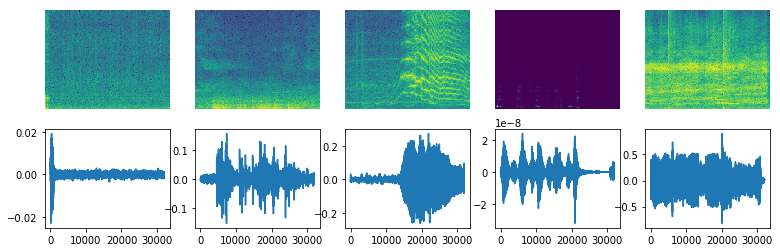

In [31]:
import scipy
from scipy import signal
import IPython.display as ipd

fig, axs = plt.subplots(2, 5, figsize=(13, 4))
for idx in range(5):
    i, j = int(idx / 5), int(idx % 5)
    x = X[idx]
    sampleFreqs, segmentTimes, sxx = signal.spectrogram(x[:, 0], 16000)
    axs[i*2][j].pcolormesh((len(segmentTimes) * segmentTimes / segmentTimes[-1]),
                         sampleFreqs,
                         10 * np.log10(sxx + 1e-15))
    #axs[i*2][j].set_title(classes[seen_classes[idx]])
    axs[i*2][j].set_axis_off()
    axs[i*2+1][j].plot(x)
    #axs[i*2+1][j].set_axis_off()
    
plt.show()

for idx in range(5):
    x = X[idx]
    ipd.display(ipd.Audio(x[:, 0], rate=16000))

In [32]:
from keras.activations import relu
from keras.callbacks import EarlyStopping,TensorBoard
from keras.layers import Dense,Dropout,Conv1D,Flatten
from keras.optimizers import adam
from keras.losses import mse
from keras.models import Sequential

In [33]:
model=Sequential()
model.add(Conv1D(9,5,input_shape=(32000,1),activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(160,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(50,activation='softmax'))
model.output_shape,model.input_shape

((None, 50), (None, 32000, 1))

In [34]:
model.compile(optimizer=adam(0.01),loss='mse',metrics=['accuracy'])
early=EarlyStopping(patience=10)

In [46]:
model.fit_generator(train_gen,steps_per_epoch=20,callbacks=[early],validation_data=valid_gen,validation_steps=20,epochs=100)

Epoch 1/100
20/20 [==============================] - 51s 3s/step - loss: 0.0129 - acc: 0.0312 - val_loss: 0.0196 - val_acc: 0.0125
Epoch 2/100
20/20 [==============================] - 48s 2s/step - loss: 0.0127 - acc: 0.0312 - val_loss: 0.0196 - val_acc: 0.0063
Epoch 3/100
20/20 [==============================] - 293s 15s/step - loss: 0.0128 - acc: 0.0250 - val_loss: 0.0197 - val_acc: 0.0500
Epoch 4/100
20/20 [==============================] - 48s 2s/step - loss: 0.0131 - acc: 0.0187 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 41s 2s/step - loss: 0.0131 - acc: 0.0125 - val_loss: 0.0193 - val_acc: 0.0437
Epoch 6/100
20/20 [==============================] - 43s 2s/step - loss: 0.0131 - acc: 0.0063 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 39s 2s/step - loss: 0.0129 - acc: 0.0187 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 8/100
20/20 [==============================] - 37s 2s/step - lo

In [49]:
loss,acc=model.evaluate_generator(test_gen,steps=10)
print("Loss: {0}    Accuracy: {1}".format(loss,acc))

Loss: 0.01961666774004698    Accuracy: 0.0125


In [6]:
!jupyter nbconvert --to html Classify_sound.ipynb

[NbConvertApp] Converting notebook Classify_sound.ipynb to html
[NbConvertApp] Writing 279820 bytes to Classify_sound.html
